<center><img src="https://cdn.greenoptimistic.com/wp-content/uploads/2017/03/Solar-Panels-1482484513.jpg?x81535" alt="Solar panels in factory" width=600 height=300></center>


# Green energy portfolio: Solar panel evaluation
#### Geographical evaluation for solar panel installation on different locations across a distribution network and it's predicted impact on it's green energy portfolio.

### Problem

In order to increase clean energy consumption across the company's distribution network, an evaluation on the installation of solar panels is required. A solar panel's efficiency and project viability depends on the <u>solar power potential (kWh/m3-year)</u> (climatolgical conditions) of the area, <u>current electricity tariff ($/kWh)</u> and already existing <u>clean energy mix (%)</u> from the national grid. 
As such, an analysis pertaining to it's efficiency by location and impact on each type of facility is performed.

Other information relevant to a solar panel's effectiveness is also gathered. This includes: inclination, orientation, seasonal solar potential.

Climatological information is gathered by calling NASA's API at: https://power.larc.nasa.gov  
Data access viewer supplied by NASA: https://power.larc.nasa.gov/data-access-viewer/ 

In order to make a project proposal and optimize savings, location data, clean electricity mix of the national grid (%), as well as current electricity costs ($/kWh) are gathered from internal company databases.

___Note: Locations, as well as any confidential information have been modified or removed from original world-wide analysis and replaced by public datasets.___

## Table of contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
<ul>
<li>1. <a href="#link1">Solar energy potential</a>  </li>

<li>2. <a href="#link2">Load datasets</a></li>
<ul>
    <li>2.1 <a href="#link2.1">Location data</a></li>
    <li>2.2 <a href="#link2.2">Electricity tariffs</a></li>
    <li>2.3 <a href="#link2.3">Clean energy mix</a></li>
</ul>
<li>3. <a href="#link3">NASA's Solar Data Glossary</a></li>
<ul>
<li>3.1 <a href="#link4">Full append data table with calculated yearly avg solar potential</a></li>

<li>3.2 <a href="#link5">Solar potential appended database for optimal alignment of solar panels</a></li>
<ul>
<li>3.2.1 <a href="#link6">Map 1: Solar power potentail by location</a></li>

<li>3.2.2 <a href="#link7">Map 2: Solar power potential by facility type</a></li>
</ul>
<li>3.3 <a href="#link8">Solar data distribution</a></li>
</ul>
<li>4. <a href="#link9">Data analysis</a></li>
    <ul>
    <li>4.1 <a href="#link10">Recommended sites for solar panel investment</a></li>
    </ul>
<li>5. <a href="#Next Steps">Next Steps</a></li>
</ul>
    </font>
    </div>

### <a id="link1"> </a>1. Solar energy potential

Annual average solar radiation on tilted panels __(H)__ indicates the amount of solar energy that is theoretically possible to obtain in a given location. It is measured in kWh/m3 over a period of time. In this case, this document obtained from NASA's The Power Project API.  
It considers the climatological conditions, as well as the solar panel orientation and inclination. Factors which are optimal when positioned so as to directly face the sun for the largest amount of time possible.  

The global formula to estimate the electricity generated in output of a photovoltaic system is :

           E = A * r * H * PR

__E__ = Energy (kWh)  
__A__ = Total solar panel Area (m2)  
__r__ = solar panel yield or efficiency(%)  
__H__ = Annual average solar radiation on tilted panels (shadings not included)  
__PR__ = Performance ratio, coefficient for losses (range between 0.5 and 0.9, default value = 0.75)  

<i>__r__ is the yield of the solar panel given by the ratio : electrical power (in kWp) of one solar panel divided by the area of one panel.  
Example : the solar panel yield of a PV module of 250 Wp with an area of 1.6 m2 is 15.6%.
Be aware that this nominal ratio is given for standard test conditions (STC) : radiation=1000 W/m2, cell temperature=25 celcius degree, Wind speed=1 m/s, AM=1.5.  
The unit of the nominal power of the photovoltaic panel in these conditions is called "Watt-peak" (Wp or kWp=1000 Wp or MWp=1000000 Wp).  
</i>  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from flatten_json import flatten
import folium
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.colors
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"


### <a id="link2"> </a>2. Load datasets

#### <a id="link2.1"> </a>2.1 Location data

In [2]:
location_data = pd.read_excel("Data\\European-Cities.xlsx",header = 0) #Read location data. table of site names, long/lat.
location_data.dropna(axis=0,inplace=True)
#print(location_data.shape)
#print(location_data.dtypes)

In [3]:
#Change data types and replace commas with points
for col in ['Latitude', 'Longitude']:
    location_data[col] = location_data[col].apply(lambda x: str(x).replace(',','.')) #Replace commas (,) with point (.) in Latitude and Longitude columns
    location_data[col] = pd.to_numeric(location_data[col]) # Change data types

#location_data.dtypes #verify correct data types

The original european cities database contains +250,000 cities. However, for simplicity and calculation efficiency for this example, only __250 cities__ will be mapped and analyzed. The rest are dropped.

In [4]:
np.random.seed(10)
n_rows_to_keep = 250

remove_n = location_data.shape[0]-n_rows_to_keep
drop_indices = np.random.choice(location_data.index, remove_n, replace=False)
location_data = location_data.drop(drop_indices)

#location_data.shape

In [5]:
#location_data.info()

In [6]:
print('Total rows of information loaded:',location_data.shape[0])
location_data.head()


Total rows of information loaded: 250


,European City,Country (ISO 3166-2),Latitude,Longitude,Facility Type
1366,Augberg,AT,46.8500,15.8000,Warehouse
6871,Gleienfeld,AT,47.9456,15.5684,Dist. Center
7290,Grand im Graben,AT,47.2865,15.7821,Production Site
9289,Heitzerhof,AT,48.2367,15.8067,Dist. Center
9372,Herberstein,AT,47.2000,15.8000,Dist. Center


In [7]:
default_lat = 52.516316 #default lat focused on Europe
default_long = 13.377825 #default long focused on Europe
location_map = folium.Map(location=[default_lat,default_long],zoom_start=4) #initialize map

for df_row in range(0,len(location_data.values)): #draw circle markers for all sites. Include Site name, lat/long, potential kWh
    folium.Marker(location=[location_data["Latitude"].iloc[df_row],location_data["Longitude"].iloc[df_row]],
                 tooltip='Country: '+location_data['Country (ISO 3166-2)'].iloc[df_row] +'<br>' +'City: ' + location_data['European City'].iloc[df_row]).add_to(location_map)
    
location_map

#### <a id="link2.2"> </a> 2.2 Electricity tariffs

In [8]:
tariffs = pd.read_excel("Data//Electricity price by country (Europe).xlsx",sheet_name='Electricity prices',header=11)

#Clean up dataset. Empty or incorrect values replaced with historic average.
tariffs.replace(":",np.nan,inplace=True)
tariffs=tariffs.T.fillna(tariffs.mean(axis=1)).T

for n in range(2,12):
    tariffs.iloc[:,n] = pd.to_numeric(tariffs.iloc[:,n])

print('Total rows of information loaded:',tariffs.shape[0])
print('Values in [EUR/kWh]')
tariffs.head()

Total rows of information loaded: 41
Values in [EUR/kWh]


,Country,Country ISO (3166-2),2016-S1,2016-S2,2017-S1,2017-S2,2018-S1,2018-S2,2019-S1,2019-S2,2020-S1,2020-S2
0,Belgium,BE,0.0850,0.0879,0.0816,0.0721,0.0765,0.0812,0.0807,0.0802,0.0795,0.0810
1,Bulgaria,BG,0.0992,0.0778,0.0753,0.0780,0.0800,0.0835,0.0877,0.0858,0.0805,0.0833
2,Czechia,CZ,0.0720,0.0721,0.0677,0.0699,0.0722,0.0710,0.0646,0.0661,0.0716,0.0713
3,Denmark,DK,0.0588,0.0633,0.0616,0.0629,0.0593,0.0651,0.0635,0.0617,0.0540,0.0615
4,Germany,DE,0.0788,0.0793,0.0761,0.0786,0.0771,0.0780,0.0855,0.0718,0.0849,0.0885


In [9]:
'''fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(15,4))
tariffs.mean(axis=0).plot(kind='line', ax=ax[0], title='Avg. Electricity tariffs [EUR]')
sns.lineplot(data=pd.melt(tariffs,['Country', 'Country ISO (3166-2)']),x='variable', y="value",hue='Country',ax=ax[1],legend=False).set_title('Electricity tariffs per country [EUR]')
plt.xticks(rotation=70)
plt.annotate('Cyprus',xy=(5.5,0.150),xytext=(6,0.165),arrowprops=dict(facecolor='black'))
plt.tight_layout()
plt.show()'''

'fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(15,4))\ntariffs.mean(axis=0).plot(kind=\'line\', ax=ax[0], title=\'Avg. Electricity tariffs [EUR]\')\nsns.lineplot(data=pd.melt(tariffs,[\'Country\', \'Country ISO (3166-2)\']),x=\'variable\', y="value",hue=\'Country\',ax=ax[1],legend=False).set_title(\'Electricity tariffs per country [EUR]\')\nplt.xticks(rotation=70)\nplt.annotate(\'Cyprus\',xy=(5.5,0.150),xytext=(6,0.165),arrowprops=dict(facecolor=\'black\'))\nplt.tight_layout()\nplt.show()'

In [10]:
print('Avg. Tariffs per period:')
tariffs.mean(axis=0)

Avg. Tariffs per period:


2016-S1    0.081260
2016-S2    0.079435
2017-S1    0.076750
2017-S2    0.075561
2018-S1    0.076794
2018-S2    0.080346
2019-S1    0.081960
2019-S2    0.081570
2020-S1    0.080949
2020-S2    0.080485
dtype: float64

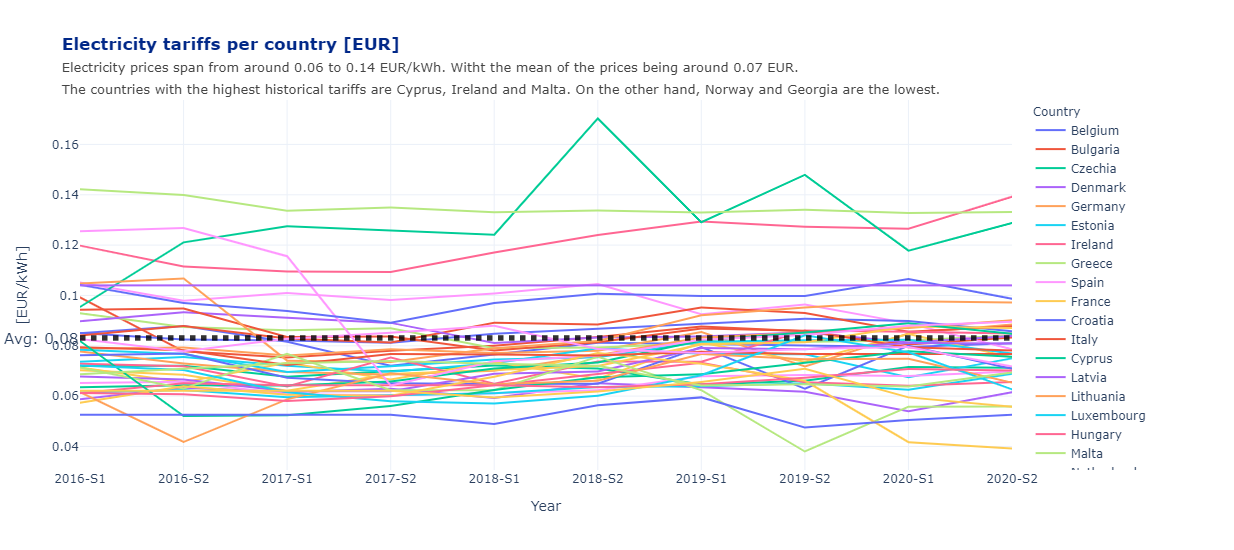

In [11]:
fig = px.line(pd.melt(tariffs,['Country', 'Country ISO (3166-2)']),x='variable', y="value",color='Country', 
                    title='<span style="color:#012888;font-weight:bold">Electricity tariffs per country [EUR]</span>'+'<br>'+
                    '<span style="font-size: 13px;color:#444444;">Electricity prices span from around 0.06 to 0.14 EUR/kWh. Witht the mean of the prices being around 0.07 EUR.<br>The countries with the highest historical tariffs are Cyprus, Ireland and Malta. On the other hand, Norway and Georgia are the lowest.</span>', 
                    width =1300, height=550,
                    labels={'value':'[EUR/kWh]','variable':'Year'},
                    template='plotly_white')

fig.add_hline(y=tariffs.mean(axis=1)[1], 
              line_dash="dot", 
              line_color='#000000',
              annotation_text="Avg: " + str('{:.2f}'.format(tariffs.mean(axis=1)[1])), 
              annotation_position="left",
              annotation_font_size=15,
              line_width=5.5,
              opacity=0.8)

fig.show()

#### <a id="link2.3"> </a>2.3 Clean electricity percentages

In [12]:
clean_mix = pd.read_excel("Data//Europe clean electricity mix.xlsx")
print('Total rows of information loaded:',clean_mix.shape[0])

clean_mix.head()

Total rows of information loaded: 41


,Country ISO (3166-2),Country,Clean electricity mix (%)
0,BE,Belgium,0.09924
1,BG,Bulgaria,0.21564
2,CZ,Czechia,0.16244
3,DK,Denmark,0.37204
4,DE,Germany,0.17354


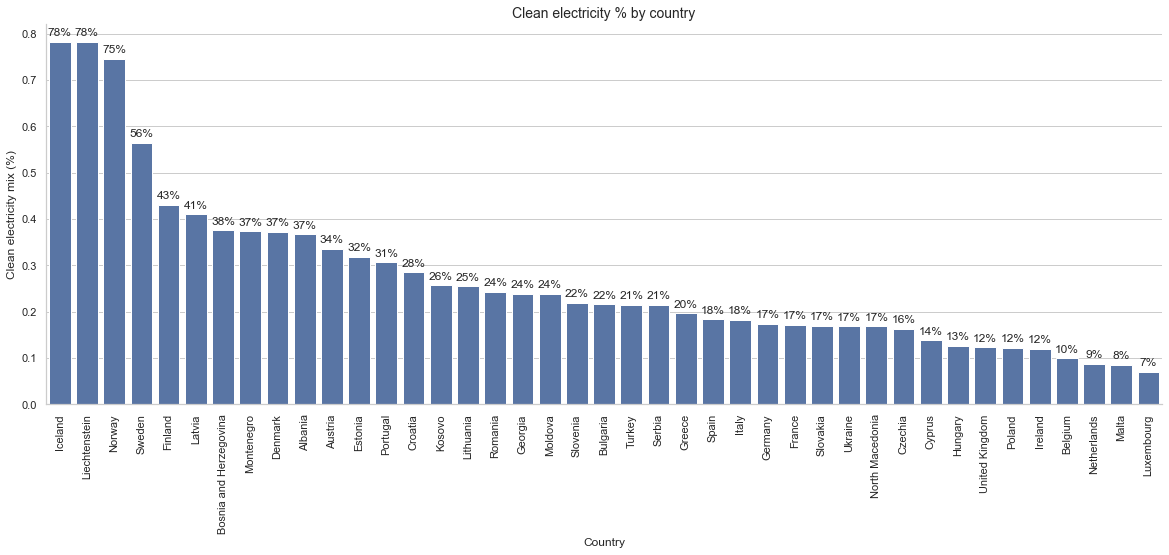

In [13]:
plt.figure(figsize=(20,7))
sns.set_theme(style="whitegrid")
bplot = sns.barplot(data=clean_mix.sort_values(by='Clean electricity mix (%)', ascending =False), x='Country', y='Clean electricity mix (%)',color='b')
sns.despine()
plt.xticks(rotation=90)
bplot.set_title("Clean electricity % by country", fontsize=14)
for p in bplot.patches:
    bplot.annotate(format(p.get_height(), '.0%'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.show()

#### 2.4 Merged data table

In [14]:
# Get clean full database. Merge databases with relevant data

#Merge location data and tariffs
merged_df = location_data.merge(tariffs,how='left',left_on='Country (ISO 3166-2)', right_on='Country ISO (3166-2)')
merged_df.drop(columns=['Country ISO (3166-2)'],axis=1,inplace=True)

#Merge clean % mix
merged_df = merged_df.merge(clean_mix.set_index('Country ISO (3166-2)'), how='left', left_on='Country (ISO 3166-2)', right_index=True, suffixes=('','_drop'))

merged_df.drop(merged_df.filter(regex='_drop$').columns.tolist(),axis=1, inplace=True)

merged_df

,European City,Country (ISO 3166-2),Latitude,Longitude,Facility Type,Country,2016-S1,2016-S2,2017-S1,2017-S2,2018-S1,2018-S2,2019-S1,2019-S2,2020-S1,2020-S2,Clean electricity mix (%)
0,Augberg,AT,46.8500,15.8000,Warehouse,Austria,0.0703,0.0685,0.0621,0.0688,0.0704,0.0720,0.0805,0.0814,0.0877,0.0871,0.33626
1,Gleienfeld,AT,47.9456,15.5684,Dist. Center,Austria,0.0703,0.0685,0.0621,0.0688,0.0704,0.0720,0.0805,0.0814,0.0877,0.0871,0.33626
2,Grand im Graben,AT,47.2865,15.7821,Production Site,Austria,0.0703,0.0685,0.0621,0.0688,0.0704,0.0720,0.0805,0.0814,0.0877,0.0871,0.33626
3,Heitzerhof,AT,48.2367,15.8067,Dist. Center,Austria,0.0703,0.0685,0.0621,0.0688,0.0704,0.0720,0.0805,0.0814,0.0877,0.0871,0.33626
4,Herberstein,AT,47.2000,15.8000,Dist. Center,Austria,0.0703,0.0685,0.0621,0.0688,0.0704,0.0720,0.0805,0.0814,0.0877,0.0871,0.33626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,?ur?ov,SK,49.0333,18.4667,Warehouse,Slovakia,0.1047,0.1067,0.0741,0.0736,0.0790,0.0819,0.0921,0.0952,0.0977,0.0972,0.16894
246,La?nov,SK,49.0667,20.9333,Production Site,Slovakia,0.1047,0.1067,0.0741,0.0736,0.0790,0.0819,0.0921,0.0952,0.0977,0.0972,0.16894
247,Milpo,SK,49.1833,21.0167,Dist. Center,Slovakia,0.1047,0.1067,0.0741,0.0736,0.0790,0.0819,0.0921,0.0952,0.0977,0.0972,0.16894
248,Mojov L?ka,SK,49.2000,18.8167,Dist. Center,Slovakia,0.1047,0.1067,0.0741,0.0736,0.0790,0.0819,0.0921,0.0952,0.0977,0.0972,0.16894


### <a id="link3"> </a>3. NASA's Solar Data glossary

NASA/POWER SRB/FLASHFlux/MERRA2/ 0.5 x 0.5 Degree Climatologies 
22-year Additional Solar Parameter Monthly & Annual Climatologies (July 1983 - June 2005)

__Parameter(s):__
- ___SI_EF_OPTIMAL:___ SRB/FLASHFlux 1/2x1/2 Solar Irradiance Optimal (kW-hr/m^2/day) 
- ___SI_EF_TRACKER:___ SRB/FLASHFlux 1/2x1/2 Solar Irradiance Irradiance Tracking the Sun (kW-hr/m^2/day) 
- ___SI_EF_TILTED_SURFACE_LATITUDE:___ SRB/FLASHFlux 1/2x1/2 Solar Irradiance for Equator Facing Latitude Tilt (kW-hr/m^2/day) 
- ___SI_EF_OPTIMAL_ANG:___ SRB/FLASHFlux 1/2x1/2 Solar Irradiance Optimal Angle (Degrees) 
- ___SI_EF_TILTED_SURFACE_HORIZONTAL:___ SRB/FLASHFlux 1/2x1/2 Solar Irradiance for Equator Facing Horizontal Surface (kW-hr/m^2/day) 
- ___SI_EF_TILTED_SURFACE_LAT_PLUS15:___ SRB/FLASHFlux 1/2x1/2 Solar Irradiance for Equator Facing Latitude Plus 15 Tilt (kW-hr/m^2/day) 
- ___SI_EF_OPTIMAL_ANG_ORT:___ SRB/FLASHFlux 1/2x1/2 Solar Irradiance Tilted Surface Orientation (N/S Orientation) 
- ___SI_EF_TILTED_SURFACE_VERTICAL:___ SRB/FLASHFlux 1/2x1/2 Solar Irradiance for Equator Facing Vertical Surface (kW-hr/m^2/day) 
- ___SI_EF_TILTED_SURFACE_LAT_MINUS15:___ SRB/FLASHFlux 1/2x1/2 Solar Irradiance for Equator Facing Latitude Minus 15 Tilt (kW-hr/m^2/day) 

In [15]:
#Makes iterative calls to NASA API for information on each long/lat. Remove """ if new lat/long are needed.
"""
n=0
df2 = pd.DataFrame()
for n_sites in location_data[["Latitude","Longitude"]].to_numpy():
    n+=1
    print(n, n_sites,"...",end='')
    lat = n_sites[0]
    long =n_sites[1]
    url = "https://power.larc.nasa.gov/cgi-bin/v1/DataAccess.py?&request=execute&identifier=SinglePoint&parameters=SI_EF_TILTED_SURFACE&userCommunity=SSE&tempAverage=CLIMATOLOGY&outputList=CSV&lat={}&lon={}".format(lat, long) 
    response = requests.get(url)
    solar_radiance=response.json()['features'][0]['properties']['parameter']
    newdf = pd.DataFrame.from_dict(solar_radiance,orient='index').reset_index()
    newdf['lat'] = lat
    newdf['long'] = long
    df2= df2.append(newdf,ignore_index=True)
    print("done")
        
print(n_sites,"...all done")
df2.to_excel("Data\\Raw_solar_radiance_data.xlsx", sheet_name = 'Raw data')
"""

df2=pd.read_excel("Data\\Raw_solar_radiance_data.xlsx",sheet_name='Raw data') #Save data in excel to avoid unnecessary future API calls.
df2 = df2.drop(columns='Unnamed: 0',axis=1)
original_data = df2.copy()

In [16]:
#Merge location data with retrieved API information. Merged on lat/long values
df2 = df2.merge(location_data,left_on=['lat','long'],right_on=["Latitude","Longitude"])
df2 = df2.rename(columns={"index":"Parameters"})
df2["avg_yearly_potential [kWh/m2]"] = df2[list(range(0,13))].mean(axis=1)*365





#### <a id="link4"> </a>3.1 Full Append data table with calculated yearly average solar potential

In [17]:
#calculate average monthly solar potentials. Transposed->calculated->transposed back, to avoid losing information on object type features
transposed = df2.T
transposed.loc["avg_yearly_potential [kWh/m2]"]=transposed.loc[list(range(0,13))].apply(pd.to_numeric,errors='ignore').mean(axis=0)*365

df2=transposed.T
df2

,Parameters,0,1,2,3,4,5,6,7,8,...,11,12,lat,long,European City,Country (ISO 3166-2),Latitude,Longitude,Facility Type,avg_yearly_potential [kWh/m2]
0,SI_EF_OPTIMAL,2.53,3.4,4.31,4.53,5.24,5.39,5.45,4.98,4.05,...,2.07,3.94,46.85,15.8,Augberg,AT,46.85,15.8,Warehouse,1439.503846
1,SI_EF_OPTIMAL_ANG,64,56,43,26,15,8,10,21.5,35.5,...,65.5,38,46.85,15.8,Augberg,AT,46.85,15.8,Warehouse,13841.923077
2,SI_EF_OPTIMAL_ANG_ORT,S,S,S,S,S,S,S,S,S,...,S,S,46.85,15.8,Augberg,AT,46.85,15.8,Warehouse,NaN
3,SI_EF_TILTED_SURFACE_HORIZONTAL,1.45,2.3,3.48,4.22,5.12,5.35,5.39,4.74,3.5,...,1.14,3.36,46.85,15.8,Augberg,AT,46.85,15.8,Warehouse,1226.680769
4,SI_EF_TILTED_SURFACE_LATITUDE,2.44,3.37,4.3,4.32,4.7,4.65,4.78,4.64,3.99,...,1.99,3.71,46.85,15.8,Augberg,AT,46.85,15.8,Warehouse,1353.588462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,SI_EF_TILTED_SURFACE_LATITUDE,1.84,2.72,3.56,4.27,4.85,4.71,4.67,4.63,3.76,...,1.48,3.41,48.0833,17.9833,Selice,SK,48.0833,17.9833,Dist. Center,1244.930769
2165,SI_EF_TILTED_SURFACE_LAT_MINUS15,1.7,2.58,3.55,4.47,5.23,5.15,5.09,4.9,3.82,...,1.36,3.51,48.0833,17.9833,Selice,SK,48.0833,17.9833,Dist. Center,1280.307692
2166,SI_EF_TILTED_SURFACE_LAT_PLUS15,1.9,2.72,3.4,3.88,4.3,4.12,4.1,4.16,3.53,...,1.53,3.17,48.0833,17.9833,Selice,SK,48.0833,17.9833,Dist. Center,1157.330769
2167,SI_EF_TILTED_SURFACE_VERTICAL,1.75,2.39,2.71,2.76,2.92,2.75,2.73,2.9,2.69,...,1.43,2.4,48.0833,17.9833,Selice,SK,48.0833,17.9833,Dist. Center,876.842308




#### <a id="link5"> </a>3.2 Solar potential appended database for optimal alignment of solar panels

In [18]:
#dataFrame for only SI_EF_OPTIMAL writing on map
optimal_df = df2.loc[df2["Parameters"]=="SI_EF_OPTIMAL"]
#pd.set_option('display.max_rows', None)
optimal_df.sort_values(by="avg_yearly_potential [kWh/m2]", ascending = False).reset_index(drop=True)

,Parameters,0,1,2,3,4,5,6,7,8,...,11,12,lat,long,European City,Country (ISO 3166-2),Latitude,Longitude,Facility Type,avg_yearly_potential [kWh/m2]
0,SI_EF_OPTIMAL,5.29,5.73,6.44,6.85,7.39,7.6,7.5,7.1,6.7,...,5.02,6.42,28.1667,-17.1667,Hermigua,ES,28.1667,-17.1667,Production Site,2342.176923
1,SI_EF_OPTIMAL,4.89,5.1,6.29,6.83,7.47,8.05,8.09,7.5,6.64,...,4.41,6.33,36.6667,-6.3583,El Bercial,ES,36.6667,-6.3583,Warehouse,2309.326923
2,SI_EF_OPTIMAL,4.96,4.98,5.91,6.63,6.92,7.65,7.74,7,6.26,...,4.55,6.04,38.8471,0.0103,El Verger,ES,38.8471,0.0103,Dist. Center,2204.880769
3,SI_EF_OPTIMAL,4.82,4.89,5.79,6.43,6.87,7.57,7.61,6.92,6.08,...,4.39,5.93,37.7833,-0.9967,Los Aljilicos,ES,37.7833,-0.9967,Production Site,2163.888462
4,SI_EF_OPTIMAL,4.32,4.5,5.79,6.39,7.04,7.62,7.69,7.21,6.36,...,3.86,5.84,37.8,-8.6833,Quinta dos Olhos de gua,PT,37.8,-8.6833,Dist. Center,2132.442308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,SI_EF_OPTIMAL,1.17,1.88,2.67,3.66,4.57,4.58,4.57,4.06,3.08,...,1.06,2.91,53.5333,-1.5667,Silkstone,GB,53.5333,-1.5667,Warehouse,1062.711538
237,SI_EF_OPTIMAL,1.15,1.73,2.56,3.67,4.59,4.61,4.64,4.07,3.07,...,0.98,2.88,52.4333,-3.5667,Cwmbelan,GB,52.4333,-3.5667,Warehouse,1052.323077
238,SI_EF_OPTIMAL,1.13,1.94,2.73,3.61,4.76,4.68,4.41,3.89,3.01,...,0.91,2.88,55.3961,-2.6853,Harwood on Teviot,GB,55.3961,-2.6853,Dist. Center,1051.2
239,SI_EF_OPTIMAL,1.14,1.72,2.56,3.67,4.58,4.61,4.64,4.07,3.06,...,0.97,2.88,52.2453,-2.1849,Sale Green,GB,52.2453,-2.1849,Warehouse,1050.357692


In [19]:
#pd.reset_option('display.max_rows')

#### <a id="link6"> </a>3.2.1 Map 1: Solar power potentail by location

In [30]:
default_lat = 52.516316 #default lat focused on Europe
default_long = 13.377825 #default long focused on Europe
norm = Normalize(vmin=df2["avg_yearly_potential [kWh/m2]"].loc[df2["Parameters"]=="SI_EF_OPTIMAL"].min(),vmax=df2["avg_yearly_potential [kWh/m2]"].loc[df2["Parameters"]=="SI_EF_OPTIMAL"].max()) #normalize values for rgb mapping
cmap=cm.hot_r #matplotlib color map selection
m = cm.ScalarMappable(norm=norm, cmap=cmap)

world_map = folium.Map(location=[default_lat,default_long],zoom_start=4) #initialize map

for df_row in range(0,len(optimal_df.values)): #draw circle markers for all sites. Include Site name, lat/long, potential kWh
    folium.CircleMarker(location=[optimal_df["lat"].iloc[df_row],optimal_df["long"].iloc[df_row]],
        radius=9,
        fill_opacity=1,
        popup=optimal_df["European City"].iloc[df_row]+"\n"+str(optimal_df["lat"].iloc[df_row])+","+str(optimal_df["long"].iloc[df_row])+"\n"+str(round(optimal_df["avg_yearly_potential [kWh/m2]"].iloc[df_row],2))+" kWh/m2-year",
        fill_color=matplotlib.colors.to_hex(m.to_rgba(optimal_df["avg_yearly_potential [kWh/m2]"].iloc[df_row])),
        color=None).add_to(world_map)
m.add_child(w)
world_map

In [21]:
default_lat = 52.516316 #default lat focused on Europe
default_long = 13.377825 #default long focused on Europe

norm = Normalize(vmin=optimal_df["avg_yearly_potential [kWh/m2]"].min(),vmax=optimal_df["avg_yearly_potential [kWh/m2]"].max()) #normalize values for rgb mapping
cmap=cm.hot_r #matplotlib color map for cicle fill
m = cm.ScalarMappable(norm=norm, cmap=cmap)

cmap_outline=plt.cm.tab10 #matplotlib color map for outline of markers

facility_type_color_n={}
n=0
for facility_type in optimal_df["Facility Type"].unique(): #fill dictionary of category:colorMap_position
    facility_type_color_n.update({facility_type:n})
    n+=1

world_map = folium.Map(location=[default_lat,default_long],zoom_start=4) #initialize map


for df_row in range(0,len(optimal_df.values)): #draw circle markers for all sites. Include Site name, lat/long, potential kWh
    
    colorOutline= matplotlib.colors.to_hex(cmap_outline(facility_type_color_n[optimal_df["Facility Type"].iloc[df_row]])) #select color for outline of marker
    
    folium.CircleMarker(location=[optimal_df["lat"].iloc[df_row],optimal_df["long"].iloc[df_row]],
        radius=9,
        fill_opacity=1,
        popup=optimal_df["European City"].iloc[df_row]+"\n"+str(optimal_df["lat"].iloc[df_row])+","+str(optimal_df["long"].iloc[df_row])+"\n"+str(round(optimal_df["avg_yearly_potential [kWh/m2]"].iloc[df_row],2))+" kWh/m2-year",
        fill_color=matplotlib.colors.to_hex(m.to_rgba(optimal_df["avg_yearly_potential [kWh/m2]"].iloc[df_row])),
        color=colorOutline,
        weight=2).add_to(world_map)


In [22]:
#Add categorical legend to the folium map. Must provide a title, list of colors and catagory labels.

from typing import Optional, List
import branca as bc
def add_categorical_legend(
    
    folium_map: folium.Map,
    title: str,
    colors: List[str],
    labels: List[str],
) -> folium.Map:
    """
    Given a Folium map, add to it a categorical legend with the given title, colors, and corresponding labels.
    The given colors and labels will be listed in the legend from top to bottom.
    Return the resulting map.
    
    Based on `this example https://github.com/mrcagney/examples_folium/blob/develop/notebooks/categorical_legend.ipynb`_.
    
    """
    # Error check
    if len(colors) != len(labels):
        raise ValueError("colors and labels must have the same length.")

    color_by_label = dict(zip(labels, colors))

    # Make legend HTML
    template = f"""
    {{% macro html(this, kwargs) %}}

    <!doctype html>
    <html lang="en">
    <head>
      <meta charset="utf-8">
      <meta name="viewport" content="width=device-width, initial-scale=1">
    </head>
    <body>
    <div id='maplegend' class='maplegend'>
      <div class='legend-title'>{title}</div>
      <div class='legend-scale'>
        <ul class='legend-labels'>
    """

    for label, color in color_by_label.items():
        template += f"<li><span style='background:{color}'></span>{label}</li>"

    template += """
        </ul>
      </div>
    </div>

    </body>
    </html>

    <style type='text/css'>
      .maplegend {
        position: absolute;
        z-index:9999;
        background-color: rgba(255, 255, 255, 1);
        border-radius: 5px;
        border: 2px solid #bbb;
        padding: 10px;
        font-size:12px;
        right: 10px;
        bottom: 20px;
      }
      .maplegend .legend-title {
        text-align: left;
        margin-bottom: 5px;
        font-weight: bold;
        font-size: 90%;
        }
      .maplegend .legend-scale ul {
        margin: 0;
        margin-bottom: 5px;
        padding: 0;
        float: left;
        list-style: none;
        }
      .maplegend .legend-scale ul li {
        font-size: 80%;
        list-style: none;
        margin-left: 0;
        line-height: 18px;
        margin-bottom: 2px;
        }
      .maplegend ul.legend-labels li span {
        display: block;
        float: left;
        height: 16px;
        width: 30px;
        margin-right: 5px;
        margin-left: 0;
        border: 0px solid #ccc;
        }
      .maplegend .legend-source {
        font-size: 80%;
        color: #777;
        clear: both;
        }
      .maplegend a {
        color: #777;
        }
    </style>
    {% endmacro %}
    """

    macro = bc.element.MacroElement()
    macro._template = bc.element.Template(template)
    folium_map.get_root().add_child(macro)

    return folium_map



#### <a id="link7"> </a>3.2.2 Map 2: Solar power potential by facility type

In [23]:
n=0
for key in facility_type_color_n.keys():
    facility_type_color_n[key]=matplotlib.colors.to_hex(cmap_outline(n))
    n+=1
add_categorical_legend(world_map,title="Facility Type",colors=facility_type_color_n.values(),labels=facility_type_color_n.keys())

#### 3.3 <a id="link8"> </a> Solar data distribution
As we can see from the following graphs, solar data is uniformly distributed amongst all facility types, most of them centering arround 1300-1400 kWh/m2-year and outliers going all the way up to 2200+.

<ipython-input-24-bd2445ca5896>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



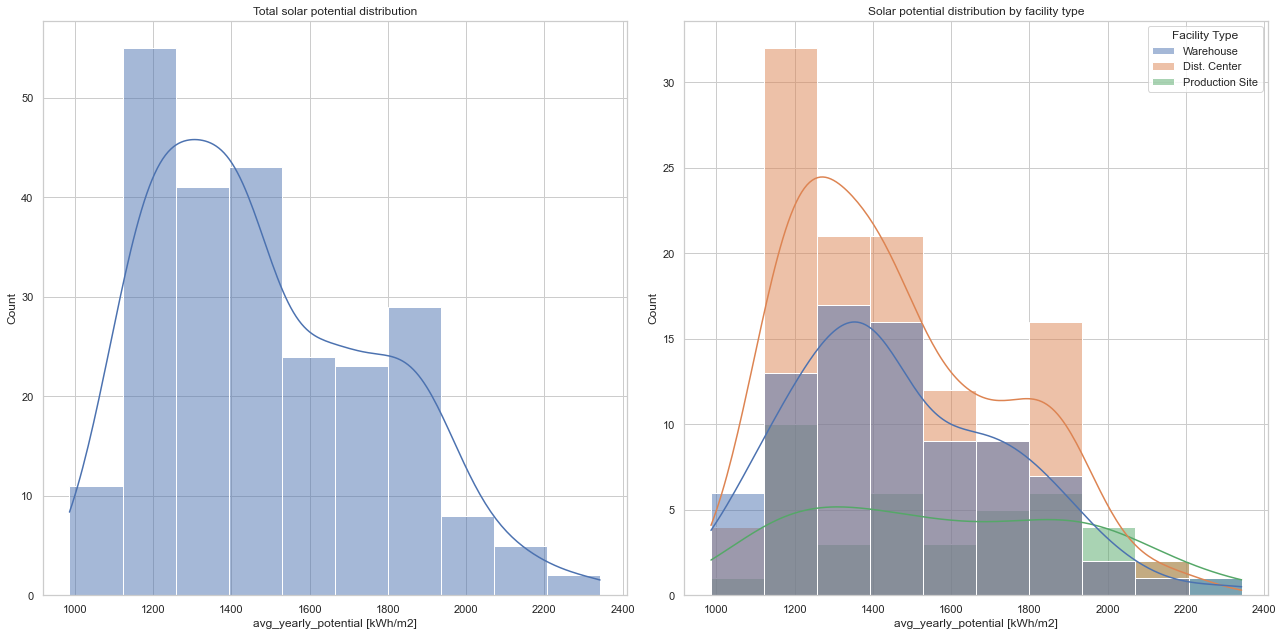

In [24]:
optimal_df['avg_yearly_potential [kWh/m2]']=pd.to_numeric(optimal_df['avg_yearly_potential [kWh/m2]'])
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
sns.histplot(data=optimal_df, x="avg_yearly_potential [kWh/m2]",kde=True).set_title('Total solar potential distribution')
plt.subplot(1,2,2)
sns.histplot(data=optimal_df, x="avg_yearly_potential [kWh/m2]",hue="Facility Type",kde=True).set_title('Solar potential distribution by facility type')
plt.tight_layout()

plt.show()

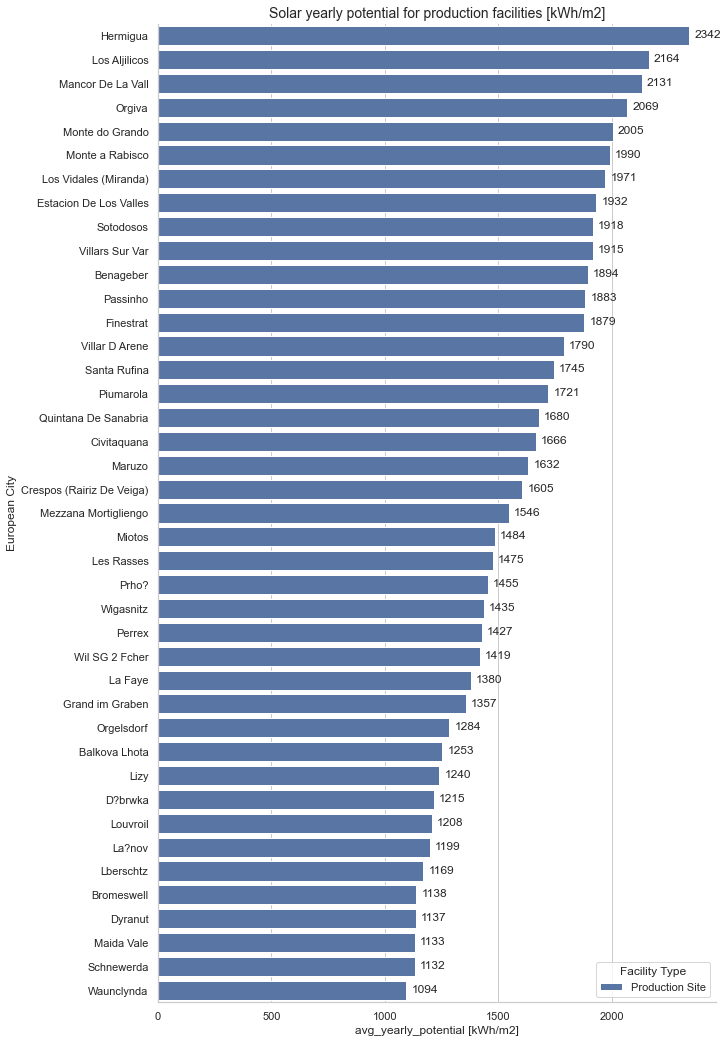

In [25]:
# Initialize the matplotlib figure
ax = plt.subplots(figsize=(10, 18))
result = optimal_df[optimal_df['Facility Type']=='Production Site'].groupby(["European City"])['avg_yearly_potential [kWh/m2]'].aggregate(np.median).reset_index().sort_values('avg_yearly_potential [kWh/m2]',ascending=False)
bplot = sns.barplot(data=optimal_df[optimal_df['Facility Type']=='Production Site'],x='avg_yearly_potential [kWh/m2]',y= 'European City',hue='Facility Type',order=result["European City"])
bplot.set_title('Solar yearly potential for production facilities [kWh/m2]', fontsize=14)

# Annotate labels for each bar
for p in bplot.patches:
    bplot.annotate("%.0f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + p.get_height()+.11),
                xytext=(5, 10), textcoords='offset points')

sns.despine()
plt.show()

### <a id="link9"> </a>4. Data analysis

#### <a id="link10"> </a>4.1. Recommended sites for solar panel investment

In [26]:
fully_merged_df = merged_df.merge(optimal_df[['Parameters','European City','avg_yearly_potential [kWh/m2]']], how='left', left_on='European City' ,right_on='European City', suffixes=('','_drop'))

fully_merged_df.drop(fully_merged_df.filter(regex='_drop$').columns.tolist(),axis=1, inplace=True)
print(fully_merged_df.shape)
fully_merged_df.head()

(250, 19)


,European City,Country (ISO 3166-2),Latitude,Longitude,Facility Type,Country,2016-S1,2016-S2,2017-S1,2017-S2,2018-S1,2018-S2,2019-S1,2019-S2,2020-S1,2020-S2,Clean electricity mix (%),Parameters,avg_yearly_potential [kWh/m2]
0,Augberg,AT,46.8500,15.8000,Warehouse,Austria,0.0703,0.0685,0.0621,0.0688,0.0704,0.072,0.0805,0.0814,0.0877,0.0871,0.33626,SI_EF_OPTIMAL,1439.503846
1,Gleienfeld,AT,47.9456,15.5684,Dist. Center,Austria,0.0703,0.0685,0.0621,0.0688,0.0704,0.072,0.0805,0.0814,0.0877,0.0871,0.33626,SI_EF_OPTIMAL,1367.907692
2,Grand im Graben,AT,47.2865,15.7821,Production Site,Austria,0.0703,0.0685,0.0621,0.0688,0.0704,0.072,0.0805,0.0814,0.0877,0.0871,0.33626,SI_EF_OPTIMAL,1356.676923
3,Heitzerhof,AT,48.2367,15.8067,Dist. Center,Austria,0.0703,0.0685,0.0621,0.0688,0.0704,0.072,0.0805,0.0814,0.0877,0.0871,0.33626,SI_EF_OPTIMAL,1281.992308
4,Herberstein,AT,47.2000,15.8000,Dist. Center,Austria,0.0703,0.0685,0.0621,0.0688,0.0704,0.072,0.0805,0.0814,0.0877,0.0871,0.33626,SI_EF_OPTIMAL,1356.115385


In [27]:
fully_merged_df.dropna(inplace=True)

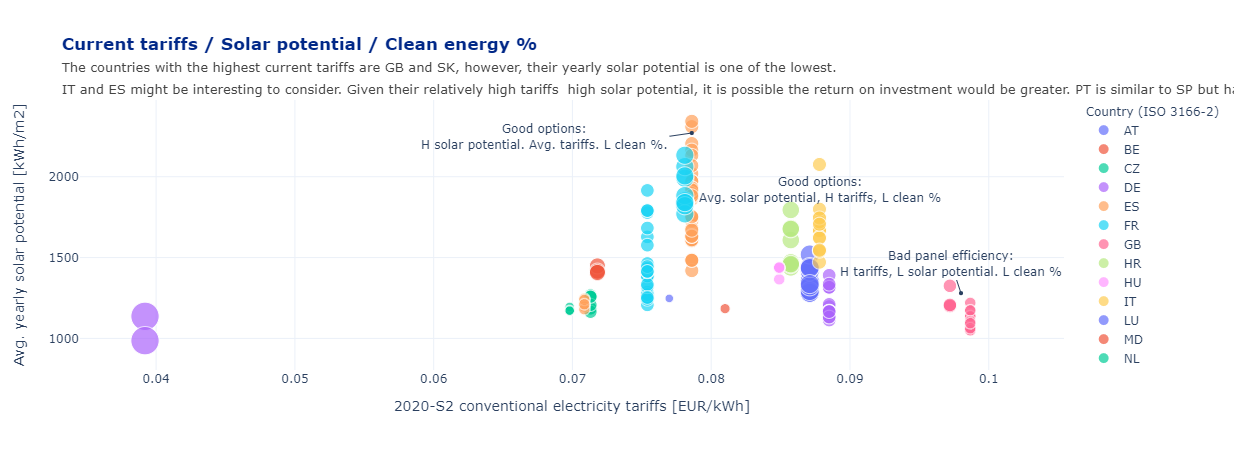

In [28]:
f = px.scatter(fully_merged_df, x='2020-S2', y='avg_yearly_potential [kWh/m2]', size='Clean electricity mix (%)', color='Country (ISO 3166-2)',template='plotly_white',
              labels={
                     "2020-S2": "2020-S2 conventional electricity tariffs [EUR/kWh]",
                     'avg_yearly_potential [kWh/m2]': "Avg. yearly solar potential [kWh/m2]",
                     'Clean electricity mix (%)': "Current clean electicity mix [%]"
                 },
              title ='<span style="color:#012888;font-weight:bold">Current tariffs / Solar potential / Clean energy %</span>'+'<br>'+
                    '<span style="font-size: 13px;color:#444444;">The countries with the highest current tariffs are GB and SK, however, their yearly solar potential is one of the lowest. <br>IT and ES might be interesting to consider. Given their relatively high tariffs  high solar potential, it is possible the return on investment would be greater. PT is similar to SP but has a higher clean mix.</span>' )

f.add_annotation(x=0.0786, y=2270, ax=0.077 ,ay=2250,
            xref='x',
            yref='y',
            axref='x',
            ayref='y',
            xanchor='right',
            text="Good options:<br>H solar potential. Avg. tariffs. L clean %.",
            showarrow=True,
            arrowhead=6)
f.add_annotation(x=0.0878, y=1900, ax=0.0878 ,ay=1920,
            text="Good options:<br>Avg. solar potential, H tariffs, L clean %",
            xref='x',
            yref='y',
            axref='x',
            ayref='y',
            showarrow=True,
            arrowhead=6)
f.add_annotation(x=0.098, y=1280, 
            xref='x',
            yref='y',
            text="Bad panel efficiency:<br>H tariffs, L solar potential. L clean %",
            showarrow=True,
            arrowhead=6)

f.show()

### <a id="Next Steps"> </a>5. Next Steps
I recommend using the above information to get an overview of potential targets and energy distributions. As next steps, a specialized source as well as an in-site and economic evaluation should be performed.

The following site provides a variety of information, reports and more accurate estimations depending on the desired aplication and may be used on fewer target sites:https://globalsolaratlas.info/map

In [29]:
with pd.ExcelWriter('Data//Raw_solar_radiance_data.xlsx', engine='openpyxl', mode='w') as writer: 
    df2.to_excel(writer, sheet_name="Append") 
    original_data.to_excel(writer, sheet_name = "Raw data")